#  **Diagnostic Médicale à partir d'images médicales**

**1.L'importation des bibliothèques**

In [1]:
import os
import cv2
import shutil
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.models import Sequential
from keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.layers import Input
import time
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# lechemin d'accès aux données
dataset_directory = '/content/drive/MyDrive/try/pfa/pre_dataset'
sous_dossiers=os.listdir(dataset_directory)
print(sous_dossiers)

['training', 'Testing']


**2.La lecture des images**

In [4]:

#La fonction de chargement des chemins d'images
def Images_Path(path):
   Images_paths = []
   labels = []
   tumor_types = os.listdir(path)

   for Type in tumor_types:
       foldpath = os.path.join(path,Type)
       images_list = os.listdir(foldpath)
       for file in images_list:
           fpath = os.path.join(foldpath,file)
           Images_paths.append (fpath)
           labels.append(Type)
   images_path = pd.Series(Images_paths,name = 'filepaths')
   etiquettes = pd.Series(labels, name = 'labels')
   dataframe = pd.concat([images_path ,etiquettes],axis='columns')
   return dataframe

In [5]:
#Le chargement des données
train_directory=dataset_directory+"/training"
train_df=Images_Path(train_directory)

test_directory=dataset_directory+"/Testing"
test_df=Images_Path(test_directory)
print(train_df.shape)
print(test_df.shape)


(5521, 2)
(1284, 2)


**3.La visualisation**


In [6]:
test_data, validation_data = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=123)

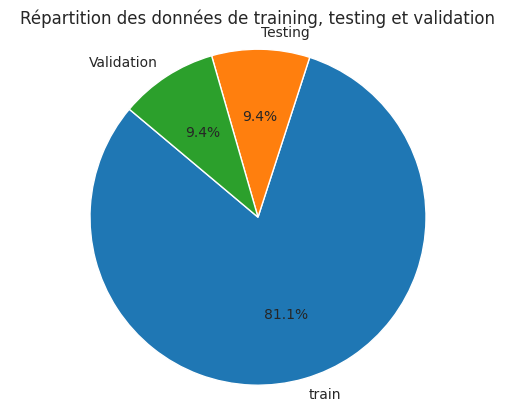

In [7]:
#la distribution de division de données
# Création des labels et des pourcentages
labels = ['train', 'Testing', 'Validation']
percentages = [(len(train_df)/6805)*100,(len(test_data)/6805)*100, (len(validation_data)/6805)*100]

# Création du diagramme circulaire
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des données de training, testing et validation')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [8]:
class_count = list(train_df['labels'].unique())
class_count

['pituitary', 'meningioma', 'glioma', 'notumor']

**4. Les Générateurs d'images**

In [9]:
batch_size=16
img_size = (224,224)
channels = 3
img_shape=(img_size[0],img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)
test_gen = ts_gen.flow_from_dataframe(test_data, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)
valid_gen = ts_gen.flow_from_dataframe(validation_data, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 5521 validated image filenames belonging to 4 classes.
Found 642 validated image filenames belonging to 4 classes.
Found 642 validated image filenames belonging to 4 classes.


**5.L'entrainement de modèle**

In [10]:
# Create the VGG16 base model
base_model = keras.applications.VGG16(include_top=False, weights='imagenet',  input_shape=(img_size[0], img_size[1], 3))


for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Create the Sequential model
model = Sequential()
model.add(Input(shape = (img_size[0],img_size[1],3)))
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu' ))
# Add a Dropout layer
model.add(Dropout(0.02))
model.add(Dense(128, activation='relu' ))
model.add(Dropout(0.02))
model.add(Dense(4, activation='softmax'))
# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 5

In [12]:
#commence l'execution de l'entrainement
from tensorflow.keras.callbacks import EarlyStopping
results = []
model.compile(optimizer = Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy', Precision(), Recall(), AUC()])
#early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
#,callbacks=[early_stopping]

batch_size = 32
epochs = 20
start_time = time.time()
# Définition de l'arrêt prématuré basé sur la perte de validation

history = model.fit(train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data=valid_gen,
                    shuffle = False)

training_time = time.time() - start_time

Epoch 1/20
346/346 [==============================] - 61s 120ms/step - loss: 0.5404 - accuracy: 0.8357 - precision: 0.8538 - recall: 0.8178 - auc: 0.9592 - val_loss: 0.2844 - val_accuracy: 0.8910 - val_precision: 0.9002 - val_recall: 0.8707 - val_auc: 0.9852
Epoch 2/20
346/346 [==============================] - 37s 106ms/step - loss: 0.1840 - accuracy: 0.9364 - precision: 0.9419 - recall: 0.9312 - auc: 0.9929 - val_loss: 0.1479 - val_accuracy: 0.9455 - val_precision: 0.9497 - val_recall: 0.9408 - val_auc: 0.9956
Epoch 3/20
346/346 [==============================] - 38s 110ms/step - loss: 0.1079 - accuracy: 0.9618 - precision: 0.9643 - recall: 0.9592 - auc: 0.9968 - val_loss: 0.1189 - val_accuracy: 0.9564 - val_precision: 0.9564 - val_recall: 0.9564 - val_auc: 0.9967
Epoch 4/20
346/346 [==============================] - 38s 111ms/step - loss: 0.0653 - accuracy: 0.9765 - precision: 0.9775 - recall: 0.9757 - auc: 0.9985 - val_loss: 0.1029 - val_accuracy: 0.9704 - val_precision: 0.9704 - v

**6.La  performance de modèle**

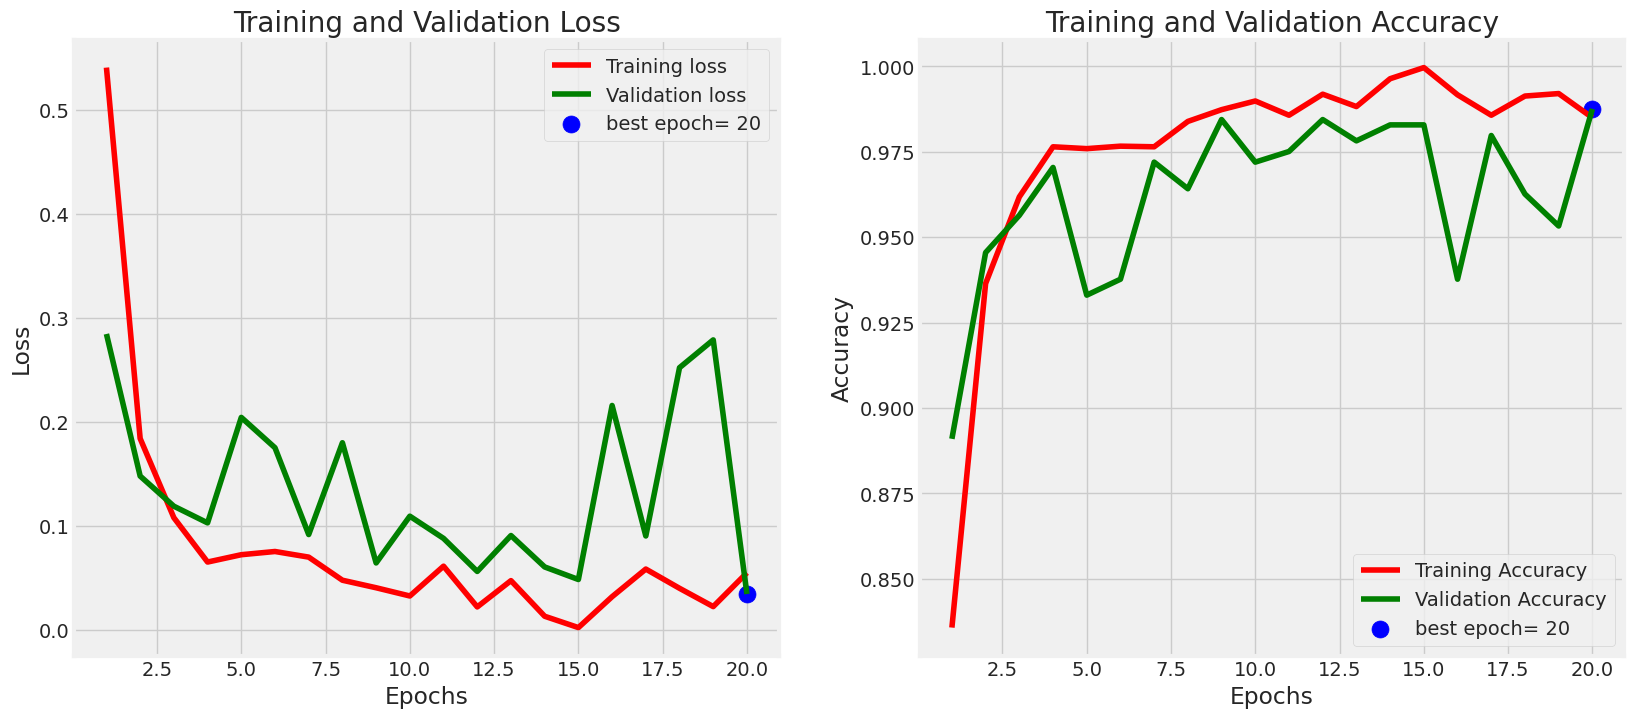

In [13]:
#la visualition de perte et la performance de partie train/validation
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
#l'evolution de modèl
train_score = model.evaluate(train_gen ,  verbose = 1)
valid_score = model.evaluate(valid_gen ,  verbose = 1)
test_score = model.evaluate(test_gen ,  verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 4s 99ms/step - loss: 0.0859 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9975
Train Loss:  0.004134312272071838
Train Accuracy:  0.9987320899963379
--------------------
Validation Loss:  0.03456637263298035
Validation Accuracy:  0.9875389337539673
--------------------
Test Loss:  0.08585144579410553
Test Accuracy:  0.9813084006309509


In [15]:
scores = model.evaluate(test_gen, verbose=0)
result = {
            'Epochs': epochs,
            'Model': 'VGG16',
            'Accuracy': f'{scores[1] * 100:.2f}%',
            'Precision': f'{scores[2] * 100:.2f}%',
            'Recall': f'{scores[3] * 100:.2f}%',
            'AUC': f'{scores[4]:.3f}',


        }
results.append(result)

# Créer le DataFrame Pandas
df = pd.DataFrame(results)
df

,Epochs,Model,Accuracy,Precision,Recall,AUC
0,20,VGG16,98.13%,98.13%,98.13%,0.997


In [16]:

#la prédiction par le modèl
test_pred = model.predict(test_gen)
y_pred = np.argmax(test_pred , axis = 1)

41/41 [==============================] - 4s 82ms/step


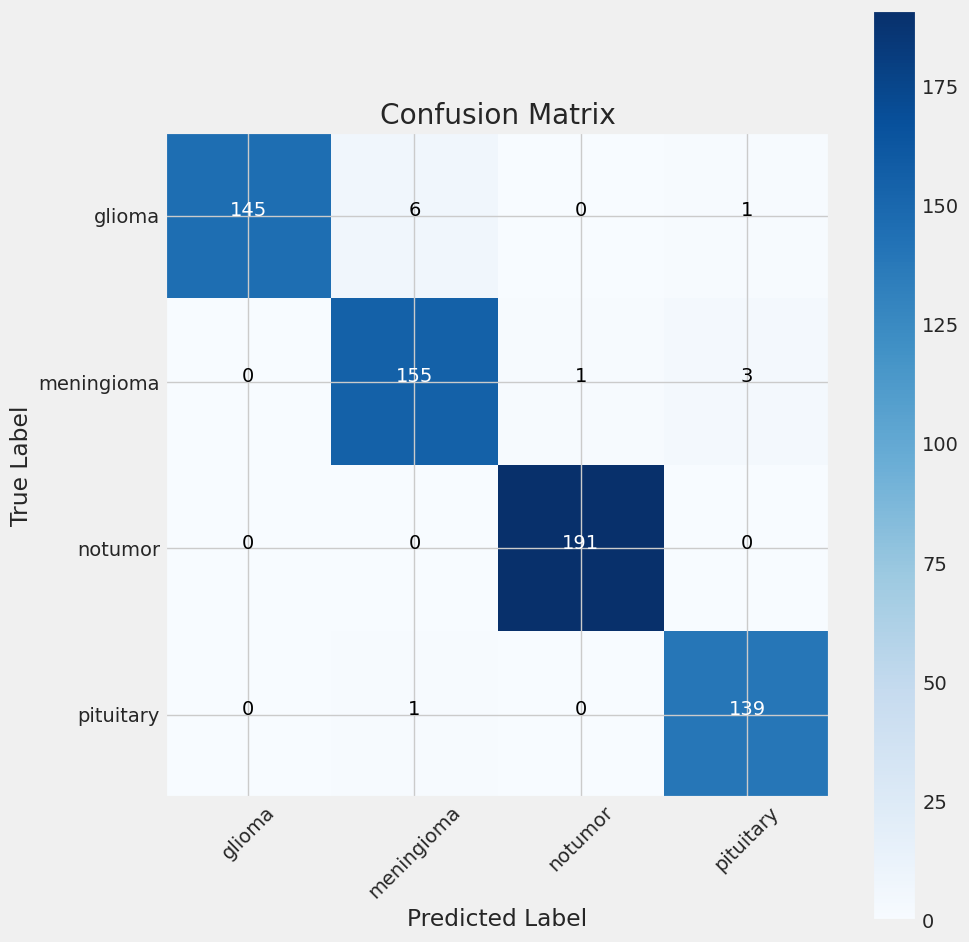

In [17]:
#La visualisation d eperformance de modèl en test
#Confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize = (10, 10))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

**La visualisation des resultats**

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display predictions on a batch of test data
def visualize_predictions(model, test_gen, class_names, num_images=16): # Changed num_images to 16
    plt.figure(figsize=(18, 18))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spaces between subplots

    # Get a batch of test data using the next method
    images, labels = next(test_gen)

    # Get the predictions for the batch of test data
    predict_batch = model.predict(images)

    for i in range(min(len(images), num_images)):  # Iterate through images up to a maximum of num_images
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i]/255.)  # Normalize image pixels
        actual_label = class_names[np.argmax(labels[i])]  # Get the name of the actual class
        predicted_label = class_names[np.argmax(predict_batch[i])]  # Get the name of the predicted class
        plt.title(f"Actual: {actual_label}\nPredected: {predicted_label}")
        plt.axis("off")

1/1 [==============================] - 0s 173ms/step


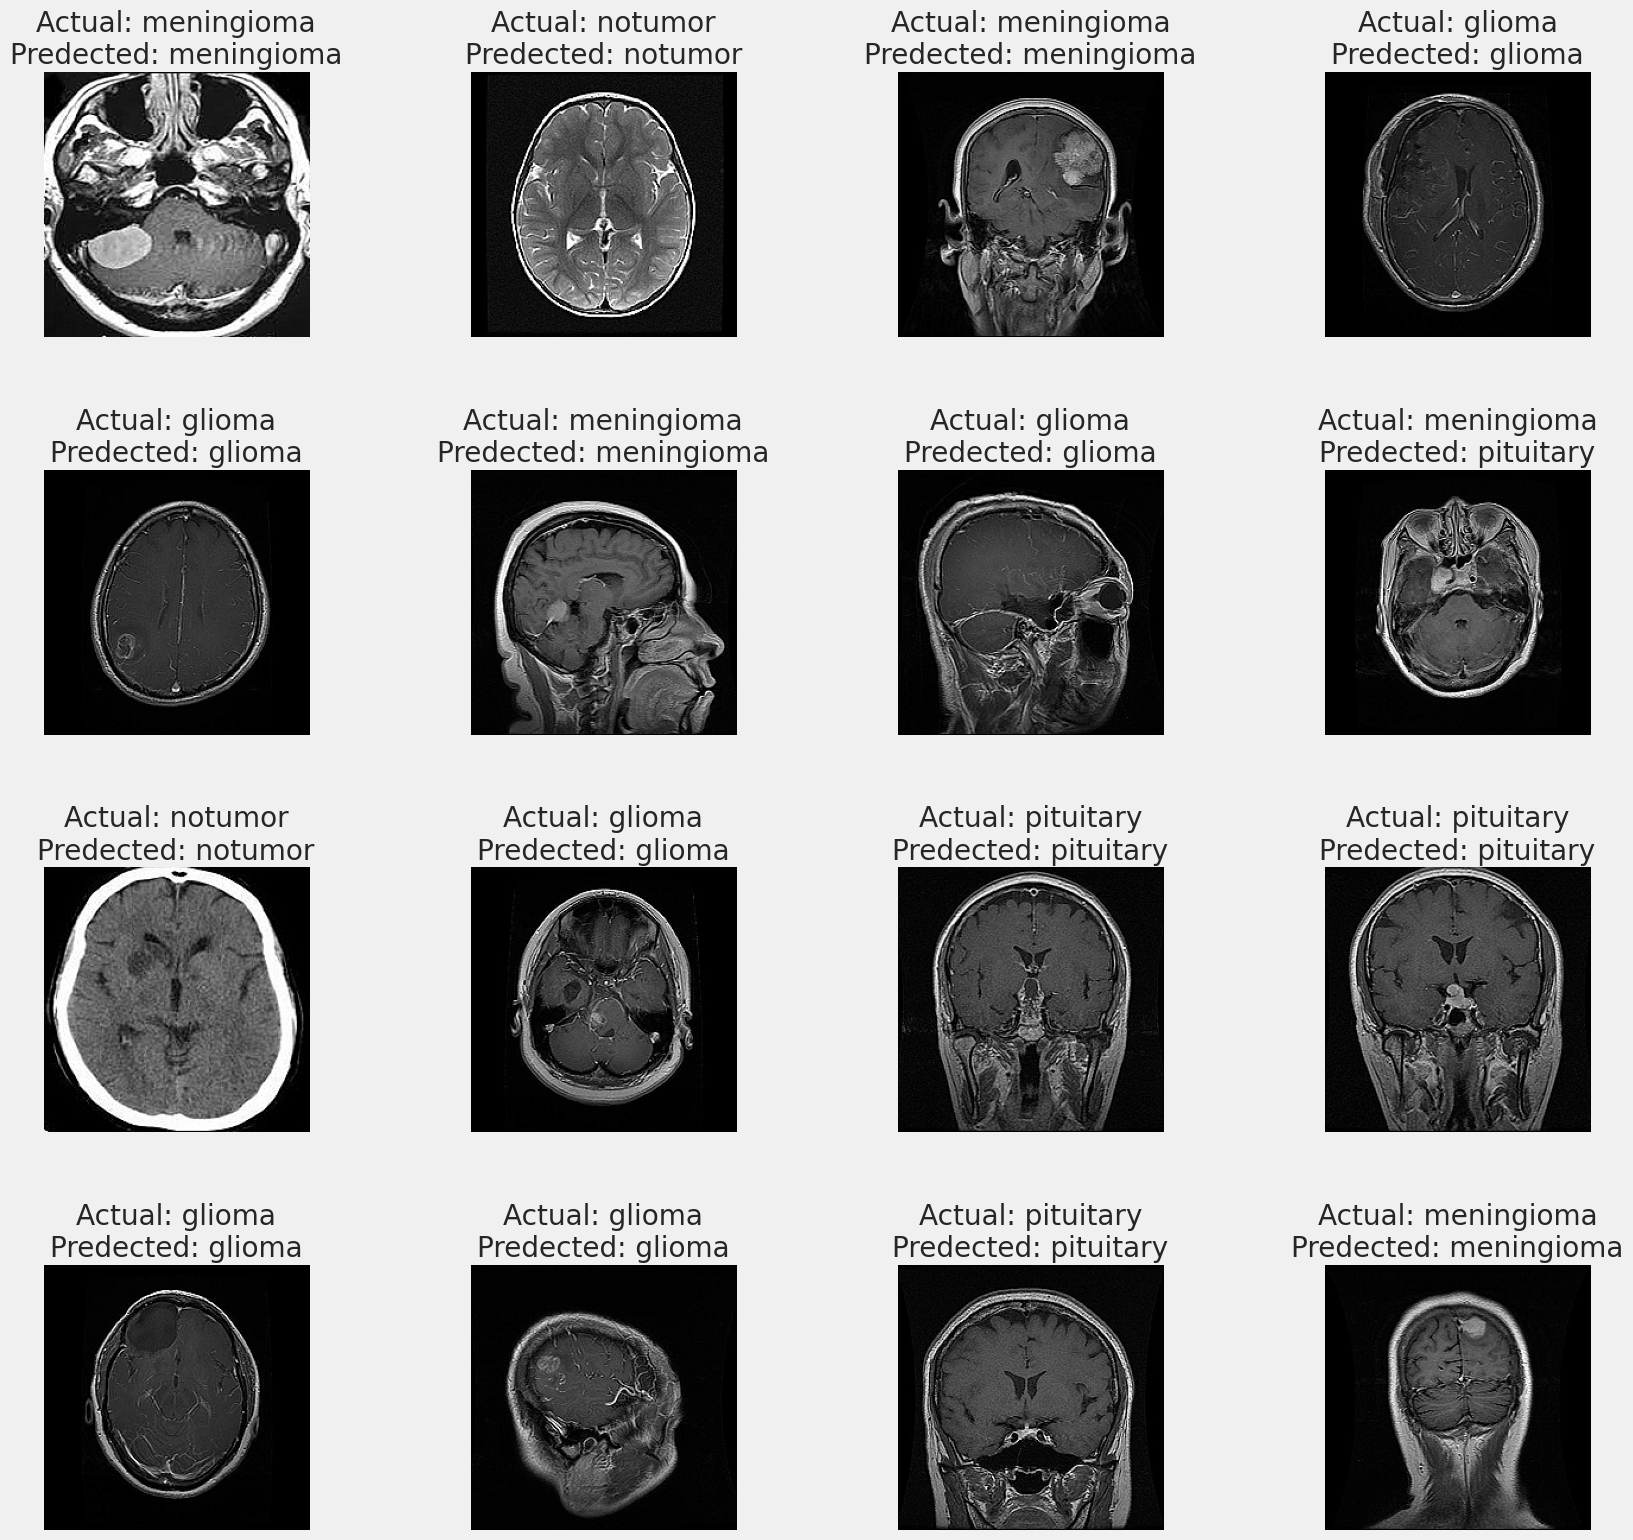

In [19]:
# Liste des noms de classe
class_names = sorted(test_gen.class_indices.keys())  # Utilisez test_gen pour obtenir les noms de classe

# Afficher les prédictions pour un lot de données de test avec le modèle CNN
visualize_predictions( model, test_gen, class_names)

**7.Le sauvegarde de modèle**

In [20]:

# Sauvegarder le modèle
model.save("/content/drive/My Drive/try/pfa/Colab Notebooks/VGG16/VGG16_VMF3.h5",include_optimizer=True)


In [21]:
#new
from sklearn.metrics import  classification_report
cr=classification_report(test_gen.classes,y_pred)
print(cr)
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       152
           1       0.96      0.97      0.97       159
           2       0.99      1.00      1.00       191
           3       0.97      0.99      0.98       140

    accuracy                           0.98       642
   macro avg       0.98      0.98      0.98       642
weighted avg       0.98      0.98      0.98       642

              precision    recall  f1-score   support

      glioma       1.00      0.95      0.98       152
  meningioma       0.96      0.97      0.97       159
     notumor       0.99      1.00      1.00       191
   pituitary       0.97      0.99      0.98       140

    accuracy                           0.98       642
   macro avg       0.98      0.98      0.98       642
weighted avg       0.98      0.98      0.98       642



In [22]:
#new
def preprocess_image(image):
    img = Image.open(image)
    img = img.resize((224, 224))  # Resize image to match model input shape
    img= np.array(img) / 255.0     # Normalize pixel values
    img_array = np.expand_dims(img ,axis=0)  # Add batch dimension
    return img_array

In [23]:
img5 = preprocess_image("/content/drive/MyDrive/try/pfa/pre_dataset/Testing/pituitary/Te-piTr_0006.jpg")

tested_img5 = model(img5)
y_pred5=np.argmax(tested_img5,axis=1)

print("pituitary , class index 3 ",y_pred5)

img7 = preprocess_image("/content/drive/MyDrive/try/pfa/pre_dataset/Testing/meningioma/Te-me_0024.jpg")

tested_img7 = model(img7)
y_pred7 =np.argmax(tested_img7,axis=1)

print("meningioma , class index 1 ",y_pred7)

img8 = preprocess_image("/content/drive/MyDrive/try/pfa/pre_dataset/Testing/glioma/Te-gl_0016.jpg")

tested_img8 = model(img8)
y_pred8=np.argmax(tested_img8,axis=1)

print( "glioma , class index 0 ", y_pred8 )

pituitary , class index 3  [1]
meningioma , class index 1  [1]
glioma , class index 0  [1]
